In [2]:
# Клонируем репозиторий Informer2020 с информером
!git clone https://github.com/zhouhaoyi/Informer2020.git
%cd Informer2020

# Устанавливаем зависимости
!pip install -r requirements.txt

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Total 576 (delta 0), reused 0 (delta 0), pack-reused 576 (from 1)
Receiving objects: 100% (576/576), 6.48 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (330/330), done.
/content/Informer2020
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 66.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 97.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× En

In [3]:
# Важный момент!! Когда загружаем данные, там есть неправильная строка, так что мы ее поправляем:
filepath = "/content/Informer2020/utils/tools.py"

with open(filepath, "r") as file:
    content = file.read()

# Заменим строку, например:
content = content.replace("np.Inf", "np.inf")

with open(filepath, "w") as file:
    file.write(content)

In [4]:
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import pandas as pd
import os

In [5]:
drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")

Mounted at /content/drive/


<ipython-input-5-b56a3be83c5c>:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")


In [6]:
# Работаем с данными
df["DateTime"] = df["timestamp"]
df = df.drop(columns=["timestamp", "Global_intensity", "Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "Global_reactive_power"])

# Приводим столбцы к числовому виду
numeric_columns = ["price"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

df = df.dropna()

# Группируем данные по часам (было по минутам...)
df = df.resample("h", on="date").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["date"].dt.hour
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["day"] = df["date"].dt.day
df["day_of_year"] = df["date"].dt.dayofyear

df = df.dropna()

In [7]:
%cd /content/Informer2020

# Сохраняем df в ./data/electricity.csv
df.to_csv("data/electricity.csv", index=False)

/content/Informer2020


In [8]:
!python main_informer.py \
  --model informer \
  --data custom \
  --root_path ./data/ \
  --data_path electricity.csv \
  --features S \
  --target Global_active_power \
  --c_out 1\
  --enc_in 1\
  --dec_in 1\
  --freq h \
  --seq_len 168 \
  --label_len 72 \
  --pred_len 24 \
  --d_model 512 \
  --n_heads 8 \
  --e_layers 2 \
  --d_layers 1 \
  --train_epochs 15 \
  --batch_size 32

Args in experiment:
Namespace(model='informer', data='custom', root_path='./data/', data_path='electricity.csv', features='S', target='Global_active_power', freq='h', checkpoints='./checkpoints/', seq_len=168, label_len=72, pred_len=24, enc_in=1, dec_in=1, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=False, mix=True, cols=None, num_workers=0, itr=2, train_epochs=15, batch_size=32, patience=3, learning_rate=0.0001, des='test', loss='mse', lradj='type1', use_amp=False, inverse=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='h')
Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftS_sl168_ll72_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 24021
val 3437
test 6894
	iters: 100, epoch: 1 | loss: 0.7647197
	speed: 0.1810s/iter; le

In [9]:
# Путь к папке результатов
result_folder = "/content/Informer2020/results/informer_custom_ftS_sl168_ll72_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_test_1"

print(os.listdir(result_folder))

# Считываем реальные и предсказанные значения
true = np.load(os.path.join(result_folder, "true.npy"))
preds = np.load(os.path.join(result_folder, "pred.npy"))

['pred.npy', 'metrics.npy', 'true.npy']


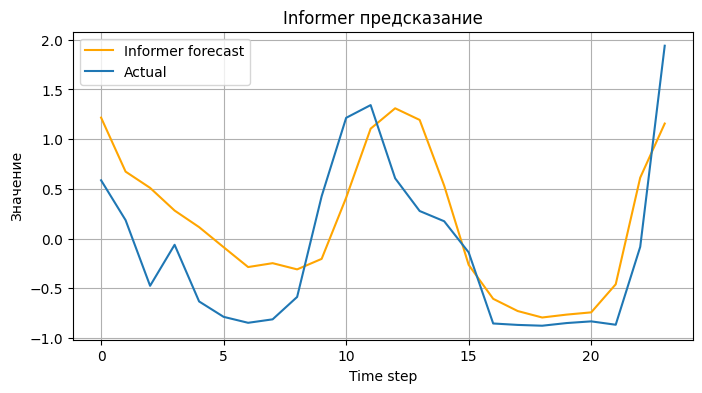

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(preds[-1], color='orange', label='Informer forecast')
plt.plot(true[-1], label='Actual')
plt.title("Informer предсказание")
plt.xlabel("Time step")
plt.ylabel("Значение")
plt.grid(True)
plt.legend()
plt.show()